In [2]:
# Operating System
import os
import gc

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd
import random

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# LightFM
from lightfm import LightFM
from lightfm.data import Dataset as lfmDataset 

# Surprise
from surprise import SVD
from surprise import Dataset as sDataset
from surprise import Reader

# Model Evaluation
from evaluation import evaluate_solution

# RAM control
from ramcontrol import check_memory_limit, memory_circuit_breaker




In [13]:
import datetime

In [3]:
memory_limit_perc = 70.

# Simplified Pipeline

The following cells provide a simplified template of the steps used on part 1 of the BLU12 Learning Notebook. These steps are not the only way to get a RS up and running and we encourage you to tweak them as you see fit.

Creating a function to save the recomendation as csv file !

In [4]:
def save_recommendations(df: pd.DataFrame, file_name: str):
    """
    Save recommendation dataframe as .csv.
    """
    
    file_path = os.path.join("data", f"{file_name}.csv")
    df.to_csv(file_path, index=False, header=False)
    print(f"Recommendations were saved on file {file_name}.csv.")


## Understanding the data

- The dataset that you selected is appropriated for building a RS?
- Do you have data regarding the items or only about the users' preference?
- Do you have a test dataset or do you have to create it?

## Load the Data

In [5]:
ratings = pd.read_csv('data/train_ratings.csv')
ratings.head()

/tmp/ipykernel_377/1056469963.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('data/train_ratings.csv')


,beer_id,user_name,review_score,review_time
0,63836,hopdog,13/20,1157587200
1,63836,TomDecapolis,13/20,1157241600
2,71716,PhillyBeer2112,14/20,958694400
3,64125,TomDecapolis,8/20,1157587200
4,64125,hopdog,8/20,1157587200


In [6]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(ratings):,} ratings in total.")

We have 2,838,374 ratings in total.


In [8]:
#How many books where rated
print(f" We have {ratings['beer_id'].unique().size:,} beers rated.")

 We have 109,833 beers rated.


In [10]:
# How many users rated at least one book?
print(f" We have {ratings['user_name'].unique().size:,} users that rated at least one beer.")

 We have 29,027 users that rated at least one beer.


books_ratings dataframe seems to be clean

In [157]:
books = pd.read_csv('books_data/BX-Books.csv', sep = ';', 
encoding= 'unicode_escape', on_bad_lines='skip')
books.head()

/tmp/ipykernel_235/163244608.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('books_data/BX-Books.csv', sep = ';',


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [158]:
books.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object

In [159]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [160]:
users = pd.read_csv('books_data/BX-Users.csv', sep = ';', 
encoding= 'unicode_escape')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


## Process and clean data
- Check if data needs to be processed and cleaned.
- Process and clean data if necessary.

In [161]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


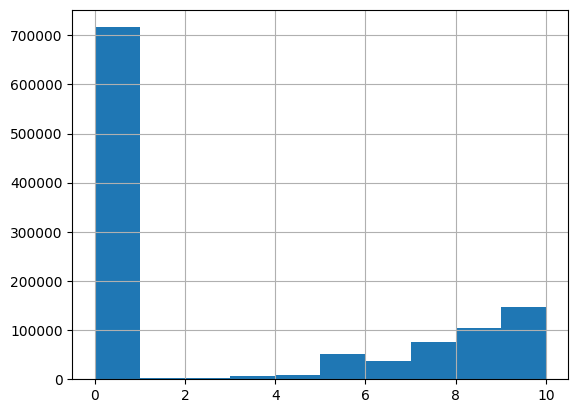

In [162]:
# Plotting the rating distribution.
books_ratings["Book-Rating"].hist();

## Identify and separate the Users
- Which users are present in the training data?
- Make sure that you identify which test users are present in the training data and which are not.
- Can you use personalized methologies for all users?

In [163]:
books_ratings_train, books_ratings_val = train_test_split(books_ratings, test_size=0.4, random_state=123)

**For this exercise I will create a list of test users, 80% of those user will be already present in the training set, the remaining users will be new users!
The total number of user in test set will be 100**

In [164]:
users_from_data = random.choices(books_ratings_train['User-ID'].tolist(), k=80)

In [165]:
new_users = []

while len(new_users) <20:
    number = random.randint(47672900,276729000)
    new_users.append(str(number))

In [166]:
test_users = users_from_data + new_users

In [167]:
len(test_users)

100

First we need to split the data into test and validation, later on the vaidation set can be user to see how out model is preforming

In [168]:
books_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Training Set

In [169]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(books_ratings_train):,} ratings in total.")

We have 689,868 ratings in total.


In [170]:
#How many books where rated
print(f" We have {books_ratings_train['ISBN'].unique().size:,} books rated.")

 We have 250,124 books rated.


In [171]:
# How many users rated at least one book?
print(f" We have {books_ratings_train['User-ID'].unique().size:,} users that rated at least one book.")

 We have 78,837 users that rated at least one book.


### Validation Set

In [172]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(books_ratings_val):,} ratings in total (validation set).")

We have 459,912 ratings in total (validation set).


In [173]:
#How many books where rated
print(f" We have {books_ratings_val['ISBN'].unique().size:,} books rated.")

 We have 192,164 books rated.


In [174]:
# How many users rated at least one book?
print(f" We have {books_ratings_val['User-ID'].unique().size:,} users that rated at least one book.")

 We have 63,027 users that rated at least one book.


To be able to compare our recommendations with actual most liked items we need to find users that have enough actual ratings to compare with. If we are measuring `map@k` with `k=20`, users must have at least 20 actual prefered items and we have to provide at least 20 recommendations. One might argue that we now have selection bias because we are specifically selecting users that have more ratings and ignoring users with fewer ratings. This is a consideration that you should take into account specially if you want to evaluate the performance of recommendations to new users. 

Here we are selecting all ratings from users with at least 20 positive reviews as our validation data.

In [175]:
books_ratings_val.head(2)

,User-ID,ISBN,Book-Rating
229535,52917,1558534202,6
817972,198711,0394426290,0


In [176]:
def select_frequent_reviewers(df: pd.DataFrame, min_nr_reviews: int = 20, min_rating: int = 8):
    """
    Select reviews from users with at least min_nr_reviews reviews with rating larger than min_rating.
    """
    
    # Select only positive reviews
    df_positive = df.copy().loc[df["Book-Rating"] >= min_rating]

    # Select users with more than min_nr_reviews positive reviews
    user_review_count = df_positive.groupby(by=["User-ID"])["ISBN"].count()
    test_users_list = list(user_review_count[user_review_count > min_nr_reviews].index)

    # Select ratings from users specified above
    df_restrict = df_positive.copy().loc[df_positive["User-ID"].isin(test_users_list)]
    
    return df_restrict

book_ratings_val_final = select_frequent_reviewers(books_ratings_val)
book_ratings_val_final.head()

,User-ID,ISBN,Book-Rating
46967,11676,0312313195,8
403255,97324,0691017778,9
739047,178522,0684835959,8
435984,104399,0671729411,10
164786,36554,0060168013,10


This data will be user later as validation set

In [177]:
users_val = book_ratings_val_final["User-ID"].unique().tolist()
print(f"We are validating recommendations with {len(users_val)} users.")

We are validating recommendations with 684 users.


In [178]:
# nr of recommendations per user
k_top = 20

def top_items_per_user(df: pd.DataFrame, user_col: str, rating_col:str, k_top: int):

    df_users_kbest = df.copy().groupby(by=[user_col])[rating_col].nlargest(k_top).reset_index()
    df_users_kbest['rank'] = df_users_kbest.groupby(by=[user_col])[rating_col].rank(method="first")
    #df_users_kbest['rank'] = df_users_kbest['rank'].astype(int) - 1
    df_recommendations = df_users_kbest.pivot(index=user_col, columns="rank", values="level_1")
    df_recommendations = df_recommendations.reset_index(drop=False)
    df_recommendations.columns = np.arange(len(df_recommendations.columns))
    return df_recommendations

val_recommendations = top_items_per_user(book_ratings_val_final, "User-ID", "Book-Rating", k_top=k_top)
val_recommendations.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,183,9801,9819,9867,9762,9838,9753,9839,9752,9873,...,9853,9789,9803,9784,9855,9856,9830,9786,9823,9866
1,638,11108,11113,11093,11142,11107,11106,11096,11095,11126,...,11076,11082,11137,11078,11121,11075,11091,11074,11081,11110
2,643,11176,11209,11211,11204,11225,11171,11185,11203,11214,...,11180,11159,11188,11190,11198,11162,11235,11183,11210,11220
3,2030,14114,14098,14070,14068,14112,14083,14115,14081,14100,...,14091,14111,14097,14078,14090,14103,14113,14082,14110,14101
4,2033,14171,14237,14144,14122,14199,14224,14257,14248,14168,...,14255,14172,14225,14236,14270,14200,14149,14239,14258,14306


In [179]:
save_recommendations(val_recommendations, "validation_recommendations")

Recommendations were saved on file validation_recommendations.csv.


## Create the Ratings Matrix

In [180]:
# YOUR CODE HERE

## Non-Personalized Recommendations
- Create non-personalized recommendations as a baseline.
- Apply the recommendations to the test users.
- Store results in the required format for submission.
- Submit baseline recommendations.

We can directly find the most popular recipes without creating a rating matrix. We'll consider that the most popular recipes are the ones that have the best score but are also rated more. By calculating the average score and the number of times a recipe was rated, we can sort the recipes and select the best 20.

In [181]:
def non_pers_reco_order(data: pd.DataFrame,
                        item_col: str,
                        rating_col:str,
                        k_top: int,
                        aggregation: list() = ["mean", "count"]):
    """
    Create an ordered list of non-personalized recommendations, from best rated to worst rated.
    """
    non_pers_ratings = data.groupby(by=[item_col])[[rating_col]].agg(aggregation)
    non_pers_ratings.columns = non_pers_ratings.columns.get_level_values(1)
    
    #The resulting column names might be different than the specified with the aggregation parameter.
    try:
        non_pers_ratings = non_pers_ratings.sort_values(by=aggregation, ascending=False).head(k_top)
    except KeyError as e:
        print(e)
        print("Check if aggregation argument results in valid column names.")
        print(f"aggregation = {aggregation}\nrating columns = {non_pers_ratings.columns}")
        raise e
        
    non_pers_reco_list = non_pers_ratings.index.to_list()
    return non_pers_reco_list


non_pers_recommendations = non_pers_reco_order(books_ratings_train, "ISBN", "Book-Rating", k_top= 20)
print(non_pers_recommendations)

['0395193958', '0395282659', '0684842319', '006440546X', '0439042445', '1561840564', '1563893339', '006050675X', '0140238026', '0316150363', '0395082560', '0441005055', '0446513857', '067978179X', '0681403225', '0689300727', '0689801505', '073291180X', '0760707251', '0786831901']


## Evaluate results
- Calculate the evaluation metric on the validation users.
- Compare it later with the personalized recommendations

Here we create recommendations for the specified users based on the non-personalized recommendations obtained above.

In [182]:
def non_pers_reco_output(user_id_list:list, non_pers_reco_list:list):
    """
    Creates a non-personalized recommendation dataframe for specified users.
    """
    nr_test_users = len(user_id_list)
    user_id_df = pd.DataFrame(user_id_list, columns = ["user_id"])
    non_pers_reco_repeated =  pd.DataFrame(pd.DataFrame(non_pers_reco_list).T.values.repeat(nr_test_users, axis=0))
    non_pers_reco_output = pd.concat([user_id_df, non_pers_reco_repeated], axis=1)
    
    # Reset columns numbering. Useful later.
    #non_pers_reco_output.columns = np.arange(len(non_pers_reco_output.columns))
    
    return non_pers_reco_output

In [183]:
non_pers_reco_solution_val = non_pers_reco_output(users_val, non_pers_recommendations)
non_pers_reco_solution_val.head()

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,11676,0395193958,0395282659,0684842319,006440546X,0439042445,1561840564,1563893339,006050675X,0140238026,...,0395082560,0441005055,0446513857,067978179X,0681403225,0689300727,0689801505,073291180X,0760707251,0786831901
1,97324,0395193958,0395282659,0684842319,006440546X,0439042445,1561840564,1563893339,006050675X,0140238026,...,0395082560,0441005055,0446513857,067978179X,0681403225,0689300727,0689801505,073291180X,0760707251,0786831901
2,178522,0395193958,0395282659,0684842319,006440546X,0439042445,1561840564,1563893339,006050675X,0140238026,...,0395082560,0441005055,0446513857,067978179X,0681403225,0689300727,0689801505,073291180X,0760707251,0786831901
3,104399,0395193958,0395282659,0684842319,006440546X,0439042445,1561840564,1563893339,006050675X,0140238026,...,0395082560,0441005055,0446513857,067978179X,0681403225,0689300727,0689801505,073291180X,0760707251,0786831901
4,36554,0395193958,0395282659,0684842319,006440546X,0439042445,1561840564,1563893339,006050675X,0140238026,...,0395082560,0441005055,0446513857,067978179X,0681403225,0689300727,0689801505,073291180X,0760707251,0786831901


In [184]:
save_recommendations(non_pers_reco_solution_val, "non_personalized_recommendations_VAL")

Recommendations were saved on file non_personalized_recommendations_VAL.csv.


In [185]:
## Second argument is the recommendation file to compare
evaluate_solution('non_personalized_recommendations_VAL', 'validation_recommendations')

0.0

## Personalized Recommendations: Collaborative Filtering
- Compute the user similarities matrix.
- Predict ratings.
- Select the best recommendations.
- Submit recommendations.

In [186]:
books_ratings_train.head(2)

,User-ID,ISBN,Book-Rating
80266,16795,0689801645,0
82516,16982,0436205580,0


In [187]:
lfmdataset = lfmDataset()
lfmdataset.fit(books_ratings_train['User-ID'], books_ratings_train['ISBN'])

In [188]:
user_id_map, user_feature_map, item_id_map, item_feature_map = lfmdataset.mapping()

In [189]:
item_id_map_reverse = {v: k for k, v in item_id_map.items()}

In [190]:
(interactions, weights) = lfmdataset.build_interactions((row for row in books_ratings_train.values))

print(repr(interactions))

<78837x250124 sparse matrix of type '<class 'numpy.int32'>'
	with 689868 stored elements in COOrdinate format>


In [191]:
lfmodel = LightFM(loss='warp')

In [192]:
lfmodel.fit(interactions)

In [193]:
def lightFM_recommendations(dataset,
                            model,
                            user_id_ext_list,
                            non_pers_reco_list,
                            k_top: int,
                            item_features = None):   
    """
    Create output dataframe with recommendations based on dataset, model and list of users.
    
    This function predicts recommendations for users specified in user_id_ext_list that are present in the lightFM dataset.
    New users are recommended the items in the non-personalized list non_per_reco_list.
    
    Parameters:
    -----------
    dataset: lightFM dataset
    
    model: lightFM trained model
    
    user_id_ext_list: list of user external IDs to predict
    
    non_pers_reco: list of non-personalized recommendations ordered from best to worst rated
    
    k_top: number of recommendations to create per user
    
    item_features: lightFM item features
    
    Returns:
    --------
    final_reco_df: dataframe with users' recommendations
    The first column has the users' ID and the remaining columns have the recommendations
    """
    
    assert len(user_id_ext_list) > 0, "User ID list length must be larger than 0."
    
    # Dataset mappings
    user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
    
    # reverse mapping
    item_id_map_reverse = {v: k for k, v in item_id_map.items()}
    user_id_map_reverse = {v: k for k, v in user_id_map.items()}
    
    
    # item internal ids
    item_id_int_list = list(item_id_map.values())
    
    # Split old users (user_id_int_list) from new users (user_id_ext_excluded)
    # Old users are defined in the ratings vectorial space.
    # New users are not defined in the ratings vectorial space.
    # New users receive non-personalized recommendations.
    user_id_int_list = []
    user_id_ext_excluded = []
    
    for user_id_ext in user_id_ext_list:
        try:
            user_id_int_list.append(user_id_map[user_id_ext])
        except:
            user_id_ext_excluded.append(user_id_ext)
    
    # Dataframe to store model recommendations
    model_reco_df = pd.DataFrame()
    
    # Model recommendations
    for user_id in user_id_int_list:
        scores = model.predict(user_id, item_id_int_list, item_features)
        top_items_ids = np.argsort(-scores)
        top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]
         
        # Individual row. Two steps are necessary for the first row to call "user_id"
        user_id_df = pd.DataFrame([user_id_map_reverse[user_id]], columns=["user_id"], dtype = int)
        top_items_ids = pd.DataFrame([top_items_ids[:k_top]])
        user_reco_df = pd.concat([user_id_df, top_items_ids], axis=1)
        
        # Concatenating rows
        model_reco_df = pd.concat([model_reco_df, user_reco_df])
        
        # Stop execution if memory is almost full
        #memory_circuit_breaker(memory_limit_perc)
        
        
    # Non-personalized recommendations
    non_pers_reco_df = non_pers_reco_output(user_id_ext_excluded, non_pers_reco_list)
    
    # Concatenating all recommendations
    if model_reco_df.shape[0] == 0:
        final_reco_df = non_pers_reco_df
    elif non_pers_reco_df.shape[0] == 0:
        final_reco_df = model_reco_df
    else:
        final_reco_df = pd.concat([model_reco_df, non_pers_reco_df])
    
    return final_reco_df

## Evaluate results (Again)
- Calculate the evaluation metric on the validation users.

In [194]:
collab_reco_val = lightFM_recommendations(lfmdataset, lfmodel, users_val, non_pers_recommendations, k_top=20)
save_recommendations(collab_reco_val, "collaborative_recommendations_VAL")

Recommendations were saved on file collaborative_recommendations_VAL.csv.


In [195]:
evaluate_solution('collaborative_recommendations_VAL', 'validation_recommendations')

0.0

In [196]:
collab_reco_test = lightFM_recommendations(lfmdataset, lfmodel, test_users, non_pers_recommendations, k_top=20)
save_recommendations(collab_reco_test, "collaborative_recommendations_TEST")

Recommendations were saved on file collaborative_recommendations_TEST.csv.


## Content-based Recommendations

- Compute the item similarities matrix.
- Predict ratings.
- Select the best recommendations.
- Submit recommendations.

Exploring and cleaning the books information data

In [200]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [211]:
try:
    books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(float)
except:
    books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(str)

In [212]:
books.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
dtype: object

In [213]:
books["Year-Of-Publication"] 

0         2002
1         2001
2         1991
3         1999
4         1999
          ... 
271355    1988
271356    1991
271357    2004
271358    1996
271359    2000
Name: Year-Of-Publication, Length: 271360, dtype: object

In [216]:
books.loc[books["Year-Of-Publication"] == books["Year-Of-Publication"].max()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers"";Jean-Ma...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


## Evaluate results (Yet again)
- Calculate the evaluation metric on the validation users.

In [198]:
# YOUR CODE HERE

## Potential improvements

At this point you can try to improve your prediction using several approaches:
- Aggregation of ratings from different sources. 
- Mixing Collaborative Filtering and Content-based Recommendations.
- Matrix Factorization.
- Could you use a classification or regression models to predict users' preference? 🤔

In [199]:
# YOUR CODE HERE